## Import packages and set up notebook

In [1]:
from __future__ import absolute_import, division, print_function
import dic
from cycler import cycler
from IPython.display import HTML
from base64 import b64encode
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

rc_dict = {'font.size': 14, 
           'font.family': 'sans-serif', 
           'font.sans-serif': ['Arial'],
           'axes.titlesize':'large',
           'lines.linewidth': 2,
           'axes.prop_cycle': cycler('color', ('#2196F3', # blue
                                               '#F44336', # red
                                               '#4CAF50', # green
                                               '#9C27B0', # purple
                                               '#FFB300', # amber
                                               '#795548', # brown
                                               '#607D8B'  # blue grey
                                              ))
}

plt.rcParams.update(rc_dict)
%matplotlib notebook

## Enter data variables

These variables must be manually entered to your test parameters

In [2]:
# path to the .mat files exported by VIC software:
dic_directory = "/home/ryan/Desktop/sample_006_mat/"

# path to the raw image file and their extension:
image_directory = "/home/ryan/Desktop/sample_006_dic/"
image_extension = ".tif"

# CSV file saved by VIC software during analysis:
csv_filename = "/home/ryan/BTSync/dic_load/FCC_2x2x1_sample-006.csv"

# column in the CSV file that contains the load data in volts
csv_load_column = 9

# full scale load from MTS card / 10 V
newtons_per_volt = 4448 / 10.0

# sample area is needed to calculate stress from load data
lattice_parameter = 30.0
sample_area = (2 * lattice_parameter)**2

## Load data files

This loads the DIC files (with .MAT extension), image files and MTS data file.

I assume the left camera was used as the reference images. If you used the right camera, simply change the `reference_camera_filenames` variable to `right_camera_filenames`. 

Warnings will be issued if a possible error is detected when loading the data.

In [3]:
dic_filenames = dic.get_filenames(dic_directory, ".mat", prepend_directory=True)
left_camera_filenames, right_camera_filenames = dic.get_image_filenames(image_directory, image_extension, 
                                                                        prepend_directory=True)

# set this to the camera filenames used for the reference during the correlation:
reference_camera_filenames = left_camera_filenames

print("Found {:d} DIC files at {}".format(len(dic_filenames), dic_directory))
print("Found {:d} image files at {}".format(len(reference_camera_filenames), image_directory))
if len(dic_filenames) != len(reference_camera_filenames):
    warnings.warn("The number of camera images must equal the number of DIC files.")
if os.path.exists(csv_filename):
    print("Found CSV file {}".format(csv_filename))
    mts_load = dic.load_csv_data(csv_filename, csv_load_column, scale=newtons_per_volt)
    print("MTS load data imported from CSV file.")
else:
    warnings.warn("Unable to find CSV file: {}".format(csv_filename))

Found 199 DIC files at /home/ryan/Desktop/sample_006_mat/
Found 199 image files at /home/ryan/Desktop/sample_006_dic/
Found CSV file /home/ryan/BTSync/dic_load/FCC_2x2x1_sample-006.csv
MTS load data imported from CSV file.


## Execute cell and use plot to choose placements of extensometers

Clicking on the plot adds a point. Adding two points creates an extensometer. Repeat until the desired number of extensometers are created.

<IPython.core.display.Javascript object>


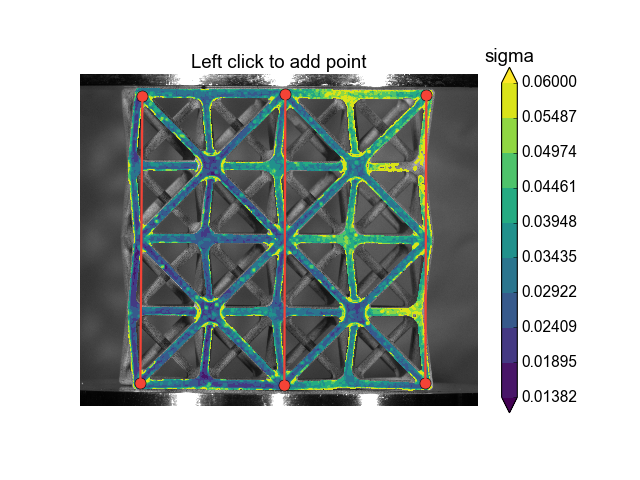

In [4]:
extensometers = dic.place_extensometers(reference_camera_filenames[0], dic_filenames[0])

## Calculate stress-strain

Strain will be calculated from the average strain of the extensometers created above. Stress is simply found by dividing the MTS load data by the sample area. These are calculated together in order to ensure that the same number of stress and strain data points were provided.

In [5]:
stress, strain = dic.stress_strain(dic_filenames, mts_load, area=sample_area, extensometers=extensometers)

Calculating stress-strain: 100%|██████████| 199/199 [00:03<00:00, 54.23it/s]
Strain calculation completed.


## Smooth the stress-strain curve

Often the output from the MTS is noisey. This will smooth some out some of the measurement error. Increase  `window_len` for greater smoothing.

<IPython.core.display.Javascript object>


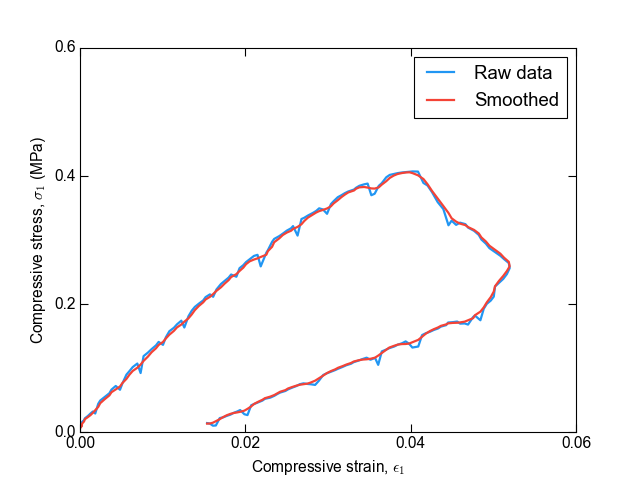

In [6]:
smoothed_stress = dic.smooth(stress, window_len=10)

axes_options = {
    "xlabel": "Compressive strain, $\\epsilon_{1}$", 
    "ylabel": "Compressive stress, $\\sigma_{1}$ (MPa)",
    "xlim"  : (0, 0.06),
    "xticks": np.arange(0, 0.08, 0.02),
    "ylim"  : (0, 0.6),
    "yticks": np.arange(0, 0.8, 0.2)
}

fig, ax = dic.plot_xy(-strain, -stress, axes_options=axes_options, plot_options={"label": "Raw data"})
dic.plot_xy(-strain, -smoothed_stress, ax=ax, plot_options={"label": "Smoothed"})
plt.legend()
plt.show()

## Prepare frame creator

A frame creator is an object that when called with a frame number ``i`` will return a ``matplotlib.figure.Figure`` corresponding to the current frame. The frame creator's `__len__` attribute must return the number frames the creator intends to create (usually the number of DIC files/images). Those are the only two requirements when creating a custom frame creator. Often the frame creator will have to be created for your specific use case. I've created one that will plot a contour overlay and an `(x, y)` plot.

<IPython.core.display.Javascript object>


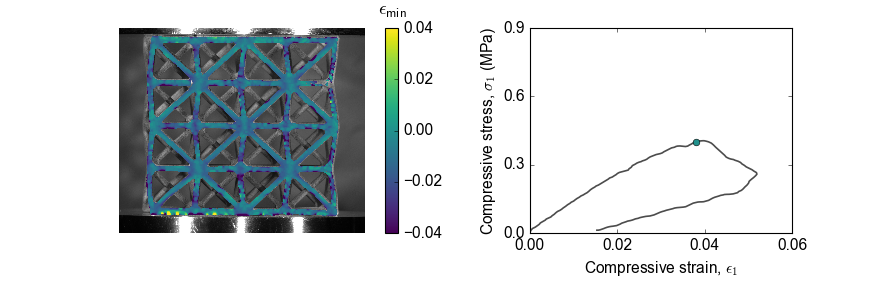

In [7]:
xy_axes_options = {
    "xlabel": "Compressive strain, $\\epsilon_{1}$", 
    "ylabel": "Compressive stress, $\\sigma_{1}$ (MPa)",
    "xlim"  : (0, 0.06),
    "xticks": np.arange(0, 0.08, 0.02),
    "ylim"  : (0, 0.9),
    "yticks": np.arange(0, 1.2, 0.3)
}

xy_plot_options = {
    "color" : (0., 0., 0., 0.7),
    "linewidth": 1.5
}

point_plot_options = {
    "markersize": 6,
    "color": plt.get_cmap("viridis")(0.5)
}

vmin = -0.04
vmax = -vmin
step = 0.02
levels = 32

overlay_contour_options = {
    "levels": np.linspace(vmin, vmax, levels)
}

colorbar_options = {
    "title": "$\\epsilon_{\\mathsf{min}}$",
    "ticks": np.arange(vmin, vmax+step, step)
}

plt.close("all")
frame_creator = dic.OverlayWithStressStrainFrameCreator(reference_camera_filenames, dic_filenames, "e2", 
                    (-strain, -smoothed_stress), figure_width=11, fractional_padding=0.5,
                    overlay_contour_options=overlay_contour_options, 
                    xy_axes_options=xy_axes_options, xy_plot_options=xy_plot_options, 
                    colorbar_options=colorbar_options, point_plot_options=point_plot_options)
fig = frame_creator(90)
plt.show()

## Export video frames

This will save `.JPG` files to the specified `output_directory` using the given options.
Notice that the frame creator from above is given as the first argument.

In [8]:
savefig_options = {
    "dpi" : 300,
    "bbox_inches": "tight"
}

dic.export_frames(frame_creator, output_directory="example/image_sequence/", 
                  output_filename="frame.jpg", savefig_options=savefig_options)

Exporting frames: 100%|██████████| 199/199 [04:13<00:00,  1.30s/it]
Frames successfully exported.


## Convert frames into a video

Convert the image sequence into a video. This requires FFMPEG to be installed, and the directory containing the executable must be on your path.

In [9]:
input_template = "example/image_sequence/frame_%3d.jpg"
output_filename = "example/movie.mp4"
dic.image_sequence_to_video(input_template, output_filename, crf=23, scale=(720, -1))

Converting images into video...
ffmpeg version 3.1.3 Copyright (c) 2000-2016 the FFmpeg developers
  built with gcc 6.1.1 (GCC) 20160802
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-avisynth --enable-avresample --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libass --enable-libbluray --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-libschroedinger --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-netcdf --enable-shared --enable-version3 --enable-x11grab
  libavutil      55. 28.100 / 55. 28.100
  libavcodec     57. 48.101 / 57. 48.101
  libavformat   

## Display the output

In [11]:
video = open(output_filename, "rb").read()
video_encoded = b64encode(video)
video_tag = \
"""
<video alt="example video" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
</video>
""".format(video_encoded.decode('ascii'))
HTML(data=video_tag)